In [3]:
!pip install transformers

In [5]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [7]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
import seaborn as sns


from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  


from transformers import T5Tokenizer, T5ForConditionalGeneration


from sklearn.model_selection import train_test_split


In [9]:
# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [11]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
df = pd.read_csv("C:\\Users\\pooja\\Downloads\\archive\\business_data.csv")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2000, 5)


,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,https://indianexpress.com/article/business/red...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business


In [15]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
headlines      0
description    0
content        0
url            0
category       0
dtype: int64


In [17]:
df['headline_length'] = df['headlines'].apply(len)  # Note: lowercase 'headlines'
df['content_length'] = df['content'].apply(len) 

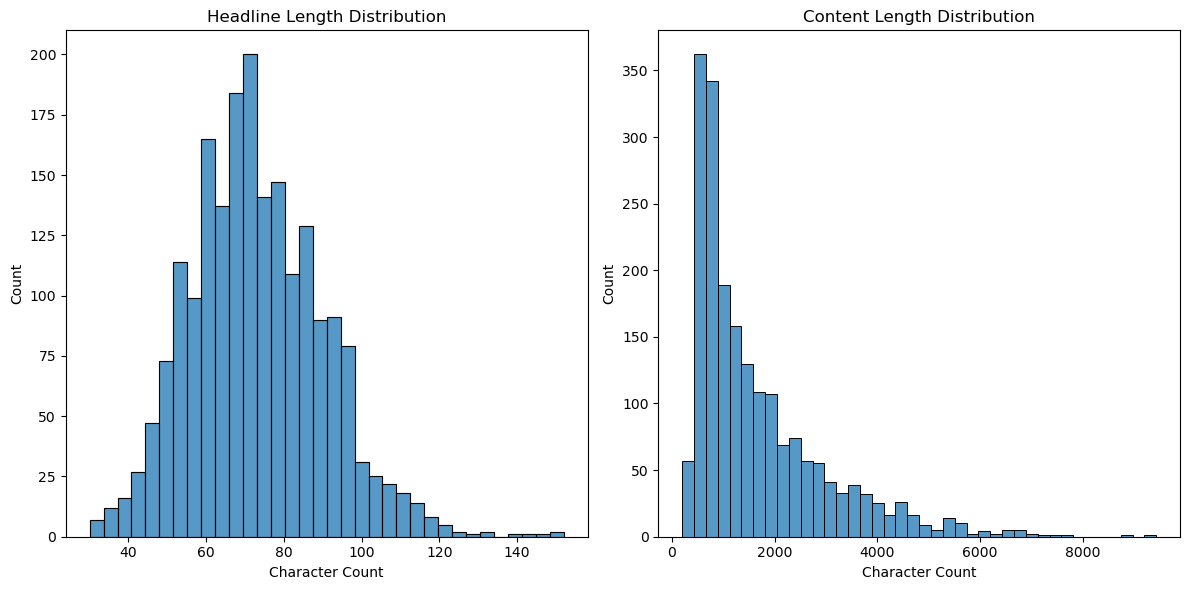

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['headline_length'])
plt.title('Headline Length Distribution')
plt.xlabel('Character Count')
plt.subplot(1, 2, 2)
sns.histplot(df['content_length'])
plt.title('Content Length Distribution')
plt.xlabel('Character Count')
plt.tight_layout()
plt.show()

In [21]:
print("\nSample Headlines and their Content:")
for i in range(3):
    print(f"\nHeadline {i+1}: {df['headlines'].iloc[i]}")
    print(f"Description: {df['description'].iloc[i]}")
    print(f"Content snippet: {df['content'].iloc[i][:200]}...")



Sample Headlines and their Content:

Headline 1: Nirmala Sitharaman to equal Morarji Desai’s record with her sixth straight budget
Description: With the presentation of the interim budget on February 1, Nirmala Sitharaman will surpass the records of her predecessors like Manmohan Singh, Arun Jaitley, P Chidambaram, and Yashwant Sinha, who had presented five budgets in a row.
Content snippet: Sitharaman, the first full-time woman finance minister of the country, has presented five full budgets since July 2019 and will present an interim or vote-on-account budget next week.
With the present...

Headline 2: ‘Will densify network, want to be at least no. 2 in any city pair’: Air India Express MD
Description: 'In terms of market share, we aim to double it by 2028 in both segments—15 per cent in the domestic and 20 per cent in short-haul international,' says AI Express’s Managing Director Aloke Singh
Content snippet: The merger of Tata group’s budget airlines Air India Express (AI Express) 

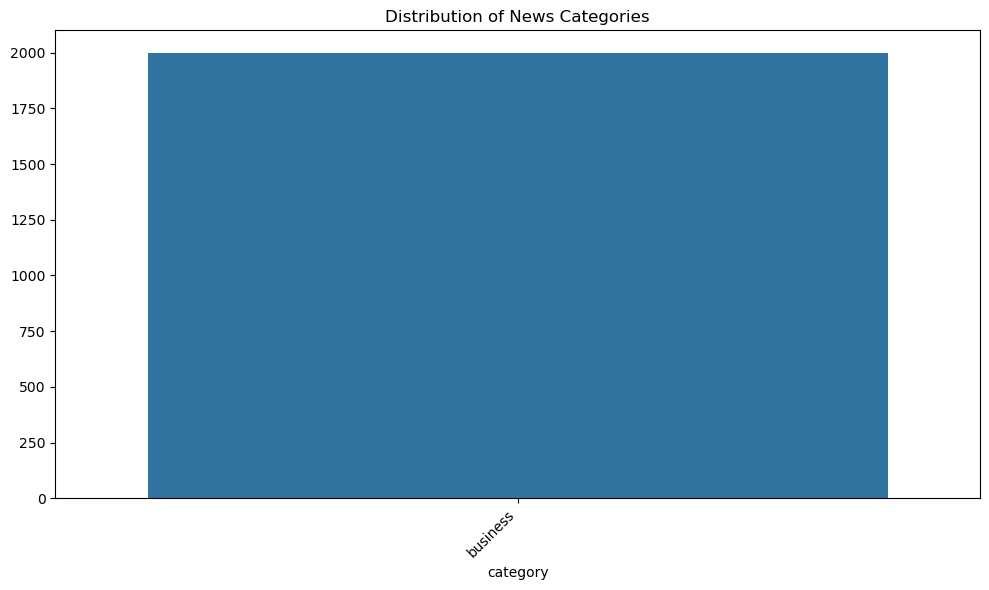

In [23]:
# Check category distribution
plt.figure(figsize=(10, 6))
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of News Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [25]:
def clean_text(text):
    """Basic text cleaning function"""
    if isinstance(text, str):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""


In [27]:
df['clean_content'] = df['content'].apply(clean_text)
df['clean_headline'] = df['headlines'].apply(clean_text)
df['clean_description'] = df['description'].apply(clean_text)


In [33]:
from tqdm import tqdm

In [35]:
# Set maximum lengths for input and output
MAX_INPUT_LENGTH = 512  # T5 can handle 512 tokens
MAX_OUTPUT_LENGTH = 64  # Headlines are shorter

# Load T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')


In [37]:
class HeadlineDataset(Dataset):
    def __init__(self, content, headlines, tokenizer, max_input_len, max_output_len):
        self.tokenizer = tokenizer
        self.content = content
        self.headlines = headlines
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len
        
    def __len__(self):
        return len(self.content)
    
    def __getitem__(self, idx):
        content = str(self.content[idx])
        headline = str(self.headlines[idx])
        
        # T5 uses a specific prefix for summarization tasks
        input_text = "summarize: " + content
        
        # Tokenize inputs and targets
        input_encoding = self.tokenizer(
            input_text, 
            max_length=self.max_input_len, 
            padding='max_length', 
            truncation=True, 
            return_tensors="pt"
        )
        
        target_encoding = self.tokenizer(
            headline, 
            max_length=self.max_output_len, 
            padding='max_length', 
            truncation=True, 
            return_tensors="pt"
        )
        
        # Get rid of the batch dimension which the tokenizer adds
        input_ids = input_encoding.input_ids.squeeze()
        attention_mask = input_encoding.attention_mask.squeeze()
        labels = target_encoding.input_ids.squeeze()
        # Replace padding token id with -100 so it's ignored in loss computation
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

In [39]:
# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Create datasets
train_dataset = HeadlineDataset(
    train_df['clean_content'].tolist(),
    train_df['clean_headline'].tolist(),
    tokenizer,
    MAX_INPUT_LENGTH,
    MAX_OUTPUT_LENGTH
)

val_dataset = HeadlineDataset(
    val_df['clean_content'].tolist(),
    val_df['clean_headline'].tolist(),
    tokenizer,
    MAX_INPUT_LENGTH,
    MAX_OUTPUT_LENGTH
)

In [41]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [43]:
pip install hf_xet

Note: you may need to restart the kernel to use updated packages.


In [45]:
# Part 4: Model Setup and Training

# Load the pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return total_loss / len(dataloader)

In [47]:
# Validation function
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [49]:
# Generate headlines
def generate_headline(content, model, tokenizer, device, max_length=64):
    model.eval()
    
    # Prepare input
    input_text = "summarize: " + content
    input_ids = tokenizer(
        input_text, 
        max_length=MAX_INPUT_LENGTH, 
        padding='max_length', 
        truncation=True, 
        return_tensors="pt"
    ).input_ids.to(device)
    
    # Generate
    output_ids = model.generate(
        input_ids, 
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    
    # Decode
    headline = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    return headline

In [51]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Training loop
NUM_EPOCHS = 3
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

Using device: cpu

Epoch 1/3

Epoch 2/3

Epoch 3/3


In [53]:
# Train
train_loss = train_epoch(model, train_loader, optimizer, device)
train_losses.append(train_loss)
    
# Validate
val_loss = validate(model, val_loader, device)
val_losses.append(val_loss)
    
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]

Train Loss: 3.9042
Validation Loss: 3.4086


In [55]:
# Save the best model
if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_headline_generator.pt')
    print("Saved best model!")


Saved best model!


In [57]:
# Load best model
model.load_state_dict(torch.load('best_headline_generator.pt'))

<All keys matched successfully>

In [59]:
# Sample a few examples from validation set
print("\nGenerated Headlines vs. Actual Headlines:")
for i in range(5):
    content = val_df['clean_content'].iloc[i]
    actual_headline = val_df['clean_headline'].iloc[i]
    generated_headline = generate_headline(content, model, tokenizer, device)
    
    print(f"\nArticle snippet: {content[:100]}...")
    print(f"Actual headline: {actual_headline}")
    print(f"Generated headline: {generated_headline}")


Generated Headlines vs. Actual Headlines:

Article snippet: Aviation watchdog DGCA has put SpiceJet under enhanced surveillance amid the budget airline facing m...
Actual headline: GST Council 28 tax on online gaming casinos and horseracing
Generated headline: DGCA has put SpiceJet under enhanced surveillance

Article snippet: Reserve Bank of India Governor Shaktikanta Das Friday said high frequency food price indicators poin...
Actual headline: High vegetable prices may push up retail inflation in near term RBI Governor
Generated headline: Reserve Bank of India Governor Shaktikanta Das said high frequency food price indicators point to an increase in prices of key vegetables

Article snippet: After opening flat domestic equities jumped higher on Wednesday led by a rally in bank stocks BSE be...
Actual headline: Sensex rises 213 pts Nifty advances to 19440 bank stocks shine JioFin hits 5 lower circuit
Generated headline: BSE benchmark Sensex gains 21327 points or 033 to close at 65433

In [61]:
pip install rouge-score

Note: you may need to restart the kernel to use updated packages.


In [63]:
from rouge_score import rouge_scorer

def calculate_rouge(actual_headlines, generated_headlines):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for actual, generated in zip(actual_headlines, generated_headlines):
        score = scorer.score(actual, generated)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    avg_scores = {k: sum(v)/len(v) for k, v in scores.items()}
    return avg_scores

In [65]:
# Generate headlines for the entire validation set (sample first 100 for speed)
sample_size = min(100, len(val_df))
actual_headlines = val_df['clean_headline'].iloc[:sample_size].tolist()
generated_headlines = []

for i in tqdm(range(sample_size), desc="Generating headlines for evaluation"):
    content = val_df['clean_content'].iloc[i]
    headline = generate_headline(content, model, tokenizer, device)
    generated_headlines.append(headline)

Generating headlines for evaluation: 100%|███████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


In [67]:
# Calculate ROUGE scores
rouge_scores = calculate_rouge(actual_headlines, generated_headlines)

print("\nROUGE Evaluation Scores:")
for metric, score in rouge_scores.items():
    print(f"{metric}: {score}")



ROUGE Evaluation Scores:
rouge1: 0.3313450245871323
rouge2: 0.15447947285337194
rougeL: 0.29510303501309193


In [69]:
# Part 7: Save model and tokenizer for future use
model.save_pretrained('./headline_generator_model')
tokenizer.save_pretrained('./headline_generator_tokenizer')

print("\nModel and tokenizer saved successfully!")


Model and tokenizer saved successfully!


In [73]:
# Part 8: Function for real-world usage
def predict_headline(article_text):
    """
    Function to generate headlines for new articles
    """
    # Clean the input text
    cleaned_text = clean_text(article_text)
    
    # Generate headline
    headline = generate_headline(cleaned_text, model, tokenizer, device)
    
    return headline

# Allow user to input an article
print("\nEnter your article text below (press Enter twice to finish):")
lines = []
while True:
    line = input()
    if line == "":
        break
    lines.append(line)
user_article = "\n".join(lines)

# Generate and display headline
print("\nGenerated Headline:")
print(predict_headline(user_article))


Enter your article text below (press Enter twice to finish):


 The Federal Reserve announced today that it will maintain its current interest rate  policy amid concerns about inflation and economic growth. The central bank's decision  comes after three consecutive quarters of moderate GDP expansion and mixed signals from  labor market indicators. Chairman Jerome Powell emphasized that the Fed remains committed  to its dual mandate of maximizing employment and stabilizing prices.
 



Generated Headline:
Federal Reserve to maintain current interest rate policy amid concerns about inflation and economic growth


In [75]:
# Part 9: Additional Analysis - Using Description Field

# Let's see if we can improve headlines by using the description field
print("\nExploring the use of description field:")

# Create a version that combines description and content
df['combined_text'] = df['clean_description'] + " " + df['clean_content']

# Compare lengths
print(f"Average content length: {df['clean_content'].str.len().mean():.2f} characters")
print(f"Average description length: {df['clean_description'].str.len().mean():.2f} characters")
print(f"Average combined length: {df['combined_text'].str.len().mean():.2f} characters")


Exploring the use of description field:
Average content length: 1601.99 characters
Average description length: 171.31 characters
Average combined length: 1774.30 characters


In [79]:
# Let's see how our model performs across different categories
print("\nCategory-specific performance:")

# Get unique categories
categories = df['category'].unique()

# For each category, evaluate on a small sample
for category in categories[:3]:  # Limit to first 3 categories for brevity
    category_df = val_df[val_df['category'] == category]
    
    if len(category_df) == 0:
        continue
    
    # Sample up to 5 articles from this category
    sample_size = min(5, len(category_df))
    sampled_df = category_df.iloc[:sample_size]
    
    print(f"\nCategory: {category}")
    
    for i in range(len(sampled_df)):
        content = sampled_df['clean_content'].iloc[i]
        actual_headline = sampled_df['clean_headline'].iloc[i]
        generated_headline = generate_headline(content, model, tokenizer, device)
        
        print(f"Actual headline: {actual_headline}")
        print(f"Generated headline: {generated_headline}")
        print("-" * 40)


Category-specific performance:

Category: business
Actual headline: GST Council 28 tax on online gaming casinos and horseracing
Generated headline: DGCA has put SpiceJet under enhanced surveillance
----------------------------------------
Actual headline: High vegetable prices may push up retail inflation in near term RBI Governor
Generated headline: Reserve Bank of India Governor Shaktikanta Das said high frequency food price indicators point to an increase in prices of key vegetables
----------------------------------------
Actual headline: Sensex rises 213 pts Nifty advances to 19440 bank stocks shine JioFin hits 5 lower circuit
Generated headline: BSE benchmark Sensex gains 21327 points or 033 to close at 6543330
----------------------------------------
Actual headline: As ATF prices surge IndiGo introduces distancebased fuel charges of Rs 3001000 per sector
Generated headline: Indias largest airline IndiGo introduces distancebased fuel charge on domestic and international flight 